In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# native
import sys
import os
from os import listdir
from collections import defaultdict
from PIL import Image
import pprint as pp
import functools
import pickle
import re

# math
import numpy as np
from sklearn.metrics import accuracy_score

# plotting
import matplotlib
from matplotlib import pyplot as plt

# extra
from tqdm import tqdm
import logging

# pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


In [2]:
requirements = {
    torch: '1',
    matplotlib: '3'
}

def check_requirements(requirements):
    for requirement in requirements:
        error_message = '{} environment does not match requirement'.format(requirement.__name__)
        assert (requirement.__version__[0] == requirements[requirement]), error_message

check_requirements(requirements)

In [3]:
cuda = torch.cuda.is_available()

if cuda:
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = 'cuda' if cuda else 'cpu'

device

'cuda'

In [4]:
class PlotGrid:
    def __init__(self, figsize=None):
        self.fig = plt.figure(figsize=figsize)
        self.ax = {}
        self.xlim = {}
        self.ylim = {}
        self.filled = {}
        self.grid = {}
    
    def plot(self, position_id, data, title=None, xlim=None, ylim=None, filled=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(*position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if xlim is not None:
            self.xlim[position_id] = xlim

        if ylim is not None:
            self.ylim[position_id] = ylim

        if filled is not None:
            self.filled[position_id] = filled
        
        if position_id not in self.filled:
            self.filled[position_id] = True

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.cla()
        ax.clear()
        if type(data).__name__ == 'Image':
            ax.imshow(data)
        else:
            if hasattr(data, 'is_cuda') and data.is_cuda:
                data = data.cpu()
            if hasattr(data, 'numpy'):
                data = data.numpy()
            ax.plot(data)

            if self.filled[position_id]:
                ax.fill_between(range(len(data)), data)

            if self.grid[position_id]:
                ax.grid(True)

            # set xlim
            if position_id in self.xlim:
                ax.set_xlim(*self.xlim[position_id])

            # set ylim
            if position_id in self.ylim:
                ax.set_ylim(*self.ylim[position_id])
        
        # set title
        if title is not None:
            ax.set_title(title)

        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.ax[position_id] = ax
    
    def prediction_plot(self, position_id, data, title=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(*position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.cla()
        ax.clear()
        plot_data = data[2]
        plot_labels = data[1]
        if hasattr(plot_data, 'is_cuda') and plot_data.is_cuda:
            plot_data = plot_data.cpu()
        if hasattr(plot_data, 'numpy'):
            plot_data = plot_data.numpy()

        ticks = range(len(plot_data)-1, -1, -1)

        ax.barh(ticks, plot_data, align='center')

        if self.grid[position_id]:
            ax.grid(True)

        # set xlim
        ax.set_xlim(0, 1)

        # set y labels
        ax.set_yticks(ticks)
        ax.set_yticklabels(plot_labels)
        
        # set title
        if title is not None:
            ax.set_title(title)

        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.ax[position_id] = ax
    
    def savefig(self, filename):
        figure_directory = os.path.join('results', 'activation-plots')
        os.makedirs(figure_directory, exist_ok=True)
        figure_path = os.path.join(figure_directory, filename)
        self.fig.savefig(figure_path, bbox_inches='tight')


In [5]:
def pathJoin(*args):
    return os.path.abspath(os.path.join(*args))


def pprint(*args):
    pp.pprint(*args)


def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))


def smooth(x, span=10):
    return [ np.mean(x[i:i+span]) for i in range(len(x) - span + 1)]


toPILImage = transforms.ToPILImage()

softmax = torch.nn.Softmax(dim=1)


In [6]:
ROOT_PATH = pathJoin(os.sep, 'var', 'node433', 'local', 'gulfaraz')

In [7]:
class BaseDataset(Dataset):

    def __init__(self, directory, split='train', transforms=None):
        self.datapoints = defaultdict(list)
        self.split = split
        self.directory = pathJoin(directory, split)
        self.datapoints = self.loadDataset()
        self.transforms = transforms

    def __len__(self):
        return len(self.datapoints)

    def __getitem__(self, idx):
        datapoint = self.loadDatapoint(idx)
        return datapoint

    def loadDatapoint(self, idx):
        raise NotImplementedError('Function "loadDatapoint" is not implemented')

    def loadDataset(self, name):
        raise NotImplementedError('Function "loadDataset" is not implemented')


In [8]:
class MiniImageNetDataset(BaseDataset):

    def __init__(self, directory, split='train', transforms=None):
        super().__init__(directory, split, transforms)
        self.descriptions = self.loadDescriptions()
        self.classes = self.loadClasses()
        self.groundtruths = self.loadValidationGroundtruths() if split == 'val' else []
        self.INDEX_IMAGE = 1
        self.INDEX_TARGET = 2
        self.INDEX_LABEL = 3

    def loadDatapoint(self, idx):
        filepath = self.datapoints[idx]
        if not os.path.isfile(filepath):
            filepath = filepath.replace('.JPEG', '.png')
        image = Image.open(filepath).convert('RGB')
        if self.split == 'val':
            groundtruth = self.groundtruths[idx]
        elif self.split == 'train':
            groundtruth = self.classes.index(filepath.split('/').pop().split('_')[0])
        if self.transforms:
            image = self.transforms(image)
        return (filepath, image, groundtruth, self.descriptions[groundtruth])

    def loadDataset(self):
        datapoints = []

        dataset_file_list_filename = '{}.txt'.format(self.split)
        dataset_file_list_path = os.path.join(self.directory, dataset_file_list_filename)

        with open(dataset_file_list_path, 'r') as dataset_file_list_file:
            for line in tqdm(dataset_file_list_file, total=sum(1 for line in open(dataset_file_list_path))):
                file_path = pathJoin(self.directory, self.sanitizeFilename(line))
                datapoints.append(file_path)
        
        return datapoints
    
    def sanitizeFilename(self, filename):
        return filename.replace('"', '').strip()

    def loadDescriptions(self):
        descriptions = []

        descriptions_filename = 'wnids_with_descriptions.txt'
        descriptions_path = pathJoin(self.directory, '..', descriptions_filename)

        with open(descriptions_path, 'r') as descriptions_file:
            for line in descriptions_file:
                description_breakdown = line.split(' ')
                description_breakdown.pop(0)
                description = ' '.join(description_breakdown).strip()
                descriptions.append(description)

        return descriptions

    def loadValidationGroundtruths(self):
        groundtruths = []

        groundtruths_filename = 'val_groundtruth.txt'
        groundtruths_path = pathJoin(self.directory, '..', groundtruths_filename)

        with open(groundtruths_path, 'r') as groundtruths_file:
            for line in groundtruths_file:
                groundtruth_breakdown = line.split(' ')
                groundtruth_breakdown.pop(0)
                groundtruth = ' '.join(groundtruth_breakdown).strip()
                groundtruths.append(int(groundtruth))

        return groundtruths

    def loadClasses(self):
        classes = []

        classes_filename = 'wnids.txt'
        classes_path = pathJoin(self.directory, '..', classes_filename)

        with open(classes_path, 'r') as classes_file:
            for line in classes_file:
                classes.append(line.strip())

        return classes

    def idx2label(self, class_idx):
        return self.classes[class_idx]


In [9]:
class DeNormalize(object):
    # Source: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = image.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


In [10]:
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

imagenet_normalization_values = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

normalize = transforms.Normalize(**imagenet_normalization_values)
denormalize = DeNormalize(**imagenet_normalization_values)


def toImage(tensor_image):
    return toPILImage(denormalize(tensor_image))

raw_transforms = transforms.Compose([
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    normalize
])

miniimagenet_dataset_path = os.path.join(ROOT_PATH, 'datasets', 'miniimagenet')

original_train_dataset = MiniImageNetDataset(miniimagenet_dataset_path, transforms=train_transforms)#raw_transforms)
original_val_dataset = MiniImageNetDataset(miniimagenet_dataset_path, split='val', transforms=test_transforms)

original_train_loader = DataLoader(original_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8)
original_val_loader = DataLoader(original_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=8)

stylized_miniimagenet_dataset_path = os.path.join(ROOT_PATH, 'datasets', 'stylized-miniimagenet-1.0')

stylized_train_dataset = MiniImageNetDataset(stylized_miniimagenet_dataset_path, transforms=train_transforms)#raw_transforms)
stylized_val_dataset = MiniImageNetDataset(stylized_miniimagenet_dataset_path, split='val', transforms=test_transforms)

stylized_train_loader = DataLoader(stylized_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8)
stylized_val_loader = DataLoader(stylized_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=8)

for dataset, loader in [
    (original_train_dataset, original_train_loader),
    (original_val_dataset, original_val_loader),
    (stylized_train_dataset, stylized_train_loader),
    (stylized_val_dataset, stylized_val_loader)
]:
    print('{} Datapoints in {} Batches'.format(len(dataset), len(loader)))

100%|██████████| 10000/10000 [00:00<00:00, 27970.96it/s]


100000 Datapoints in 6250 Batches
10000 Datapoints in 625 Batches
100000 Datapoints in 6250 Batches
10000 Datapoints in 625 Batches


<IPython.core.display.Javascript object>


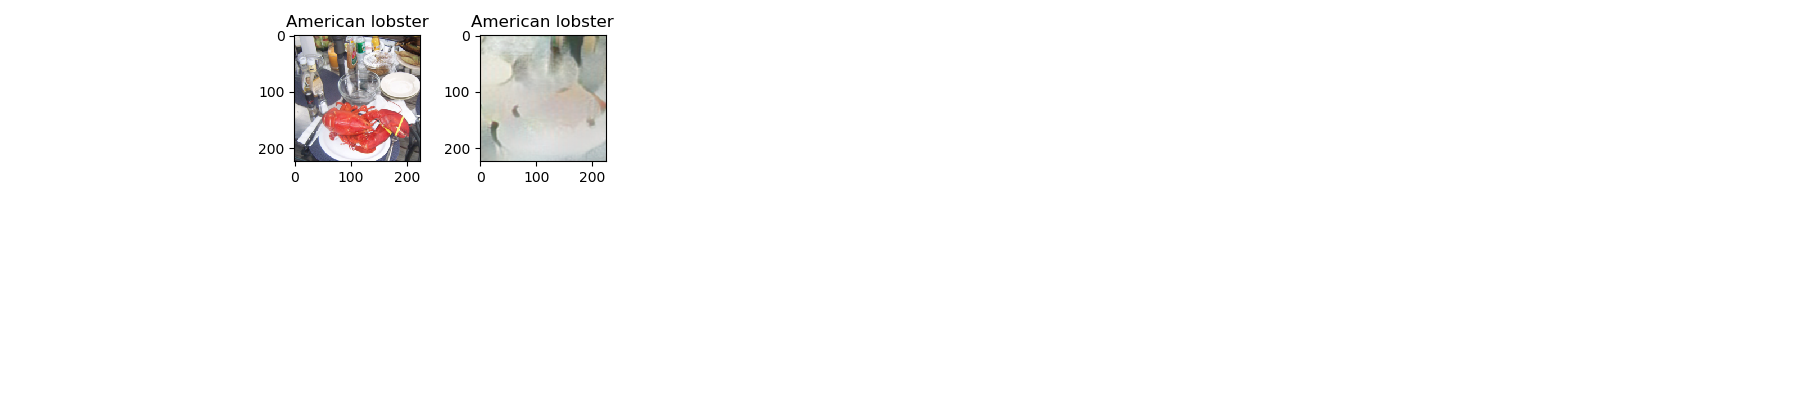

In [11]:
image_grid = PlotGrid(figsize=(9,2))

In [12]:
for index, image in enumerate(original_train_dataset):
    index_image = original_train_dataset.INDEX_IMAGE
    index_label = original_train_dataset.INDEX_LABEL
    
    # get datapoints
    original = original_train_dataset[index]
    stylized = stylized_train_dataset[index]
    
    # get images
    img = original[index_image]
    stylized_img = stylized[index_image]
    
    # plot images
    image_grid.plot((1, 2, 1), toImage(img), title=original[index_label])
    image_grid.plot((1, 2, 2), toImage(stylized_img), title=stylized[index_label])
    if (index + 1) == 9:
        break


In [13]:
def create_miniimagenet_classifier():
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=25088, out_features=4096, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=4096, out_features=200, bias=True)
    )


In [14]:
class InstanceNormBatchSwap(torch.nn.Module):
    def __init__(self, n_neurons, affine=False, eps=1e-5):
        super(InstanceNormBatchSwap, self).__init__()
        self.n_neurons = n_neurons
        self.eps = eps
        assert affine == False, 'affine parameters not implemented'

    def forward(self, input):
        assert input.shape[1] == self.n_neurons, "Input has incorrect shape"

        temp = input.view(input.size(0), input.size(1), -1)
        mean = temp.mean(2, keepdim=True).unsqueeze(-1)
        std = temp.std(2, keepdim=True).unsqueeze(-1)
        den = torch.sqrt(std.pow(2) + self.eps)
        output = (input - mean)/den
        indices = torch.randperm(input.size(0))
        output = output * std.index_select(0, indices) + mean.index_select(0, indices)

        return output
    
    def __repr__(self):
        return 'InstanceNormBatchSwap({}, eps={})'.format(self.n_neurons, self.eps)


In [15]:
class VGG_COSINE_SIMILARITY(torch.nn.Module):
    def __init__(self, layer_indices=[1, 6, 11, 20, 29], pretrained=False, eps=torch.tensor(1e-08)):
        super(VGG_COSINE_SIMILARITY, self).__init__()
        self.vgg19 = models.vgg19(pretrained=pretrained)
        self.classifier = create_miniimagenet_classifier()
        self.layer_indices = layer_indices
        self.eps = eps

    def calculate_similarity_score(self, x):
#         torch.set_printoptions(profile="full")
        flat_x = x.view(x.size(0), x.size(1), -1)
        similarity_matrix = self.calculate_cosine_similarity_matrix(flat_x)
        similarity_matrix = similarity_matrix ** 2
#         print('similarity_matrix.shape')
#         print(similarity_matrix.shape)
#         print(similarity_matrix)
        similarity_score = similarity_matrix.sum(dim=1).sum(dim=1) - similarity_matrix.size(1)
#         print('similarity_score.shape')
#         print(similarity_score.shape)
#         print(similarity_score)
#         torch.set_printoptions(profile="default")
#         raise NotImplemented
        return similarity_score

    def calculate_cosine_similarity_matrix(self, x):
#         print('x.shape')
#         print(x.shape)
        # https://pytorch.org/docs/stable/nn.html#cosine_similarity
        x_t = x.transpose(1, 2)
#         print('x_t.shape')
#         print(x_t.shape)
        x_norm = torch.norm(x, dim=2, keepdim=True)
#         print('x_norm.shape')
#         print(x_norm.shape)
        x_t_norm = x_norm.transpose(1, 2)
#         print('x_t_norm.shape')
#         print(x_t_norm.shape)
        num = torch.matmul(x, x_t)
#         print('num.shape')
#         print(num.shape)
        norm_prod = torch.matmul(x_norm, x_t_norm)
#         print('norm_prod.shape')
#         print(norm_prod.shape)
        den = torch.max(norm_prod, self.eps)
#         print('den.shape')
#         print(den.shape)
        return num / den


class VGG_IN_SINGLE(VGG_COSINE_SIMILARITY):
    def __init__(self, layer_index, instance_normalization_function=None, affine=False, pretrained=False, eps=torch.tensor(1e-08), layer_indices=[1, 6, 11, 20, 29]):
        super(VGG_IN, self).__init__(pretrained=pretrained, eps=eps, layer_indices=layer_indices)
        self.features1 = self.vgg19.features[:layer_index]
        if instance_normalization_function is not None:
            self.instance_normalization = instance_normalization_function(self.vgg19.features[layer_index].out_channels, affine=affine)
        self.features2 = self.vgg19.features[layer_index:]

    def forward(self, x):
        similarity_scores = []

        current_layer = 0

#         x = self.features1(x)
        for layer_index, layer in enumerate(self.features1):
            x = layer(x)
            if (current_layer in self.layer_indices):
                similarity_scores.append(self.calculate_similarity_score(x))
            current_layer += 1

        if hasattr(self, 'instance_normalization'):
            x = self.instance_normalization(x)

#         x = self.features2(x)
        for layer_index, layer in enumerate(self.features2):
            x = layer(x)
            if (current_layer in self.layer_indices):
                similarity_scores.append(self.calculate_similarity_score(x))
            current_layer += 1

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        layer_similarity = torch.stack(similarity_scores, dim=1)

        return x, layer_similarity


class VGG_BN(VGG_COSINE_SIMILARITY):
    def __init__(self, pretrained=False, eps=torch.tensor(1e-08), layer_indices=[2, 9, 16, 29, 42]):
        super(VGG_BN, self).__init__(pretrained=pretrained, eps=eps, layer_indices=layer_indices)
        self.vgg19_bn = models.vgg19_bn(pretrained=pretrained)
        self.features = self.vgg19_bn.features

    def forward(self, x):
        similarity_scores = []

        for layer_index, layer in enumerate(self.features):
            x = layer(x)
            if (layer_index in self.layer_indices):
                similarity_scores.append(self.calculate_similarity_score(x))

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        layer_similarity = torch.stack(similarity_scores, dim=1)
#         print('layer_similarity.shape')
#         print(layer_similarity.shape)
#         print(layer_similarity)
        return x, layer_similarity


class VGG_COSINE(VGG_COSINE_SIMILARITY):
    def __init__(self, pretrained=False, eps=torch.tensor(1e-08), layer_indices=[1, 6, 11, 20, 29]):
        super(VGG_COSINE, self).__init__(pretrained=pretrained, eps=eps, layer_indices=layer_indices)
        self.features = self.vgg19.features

    def forward(self, x):
        similarity_scores = []

        for layer_index, layer in enumerate(self.features):
            x = layer(x)
            if (layer_index in self.layer_indices):
                similarity_scores.append(self.calculate_similarity_score(x))

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        layer_similarity = torch.stack(similarity_scores, dim=1)
#         print('layer_similarity.shape')
#         print(layer_similarity.shape)
#         print(layer_similarity)
        return x, layer_similarity


In [16]:
def create_vgg19_cosine_tune_all():
    # load model from pytorch
    vgg19 = VGG_COSINE(pretrained=True)

    # train all layers
    for param in vgg19.parameters():
        param.requires_grad = True

    return vgg19


def create_vgg19_in_single_tune_all():
    vgg = VGG_IN_SINGLE(21, instance_normalization_function=torch.nn.InstanceNorm2d, pretrained=True)

    # train all layers
    for param in vgg.parameters():
        param.requires_grad = True

    return vgg


def create_vgg19_bn_all_tune_fc():
    vgg19 = VGG_BN(pretrained=True)

    # freeze cnn layers
    for param in vgg19.features.parameters():
        param.requires_grad = False

    # train fc layers
    for param in vgg19.classifier.parameters():
        param.requires_grad = True

    return vgg19


def create_vgg19_bn_all_tune_all():
    vgg19 = VGG_BN(pretrained=True)

    # train cnn layers
    for param in vgg19.features.parameters():
        param.requires_grad = True

    # train fc layers
    for param in vgg19.classifier.parameters():
        param.requires_grad = True

    return vgg19


In [17]:
def score(prediction, target):
    total = prediction.size(0)
    prediction = prediction.t()
    correct = prediction.eq(target.view(1, -1).expand_as(prediction))
    top1 = correct[:1].view(-1).float().sum(0).item()
    top5 = correct[:5].view(-1).float().sum(0).item()
    return top1, top5, total


def score_value(score, total):
    if total > 0:
        return score/total
    else:
        return 0


def score_model(model, dataloader):
    model.eval()
    total_top1 = 0
    total_top5 = 0
    total_ = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            target = batch[dataloader.dataset.INDEX_TARGET].to(device)
            input = batch[dataloader.dataset.INDEX_IMAGE].to(device)
            output, _ = model(input)
            _, predicted_classes = output.topk(5, 1, True, True)
            top1, top5, total = score(predicted_classes, target)
            total_top1 += top1
            total_top5 += top5
            total_ += total
    return total_top1/total_, total_top5/total_


def calculate_similarity_loss(similarity):
    number_of_kernels = torch.tensor([64., 128., 256., 512., 512.])
    style_weights = torch.tensor([1e3/n**2 for n in number_of_kernels])
    weighted_similarity = style_weights * similarity
    return weighted_similarity.mean() + (number_of_kernels * style_weights).sum()


# def calculate_similarity_loss(similarity):
#     return similarity.mean()


In [18]:
def validate(model, dataloader, criterion, monitor, logger, similarity_weight):
    logger.debug('Validation Start')
    model.eval()
    
    total_top1, total_top5, total_, top1_score, top5_score = 0, 0, 0, 0, 0
    loss = []
    classification_loss = []
    similarity_loss = []

#     if monitor:
#         validation_grid = PlotGrid(figsize=(9,3))
#         validation_grid.plot((1, 2, 1), score_value(total_top5, total_), title='Validation Top5 Accuracy', filled=False, ylim=(0,1))

    for batch_index, batch in enumerate(dataloader):
        output, batch_similarity = model(batch[dataloader.dataset.INDEX_IMAGE].to(device))
        target = batch[dataloader.dataset.INDEX_TARGET].to(device)

        _, predicted_class = output.topk(5, 1, True, True)
        top1, top5, total = score(predicted_class, target)

        total_top1 += top1
        total_top5 += top5
        total_ += total

        # loss
        batch_classification_loss = criterion(output, target)
        batch_similarity_loss = calculate_similarity_loss(batch_similarity)
        
        batch_loss = batch_classification_loss + (similarity_weight * batch_similarity_loss)
        loss.append(batch_loss.item())
        classification_loss.append(batch_classification_loss.item())
        similarity_loss.append(batch_similarity_loss.item())

#         predicted_descriptions = [ dataloader.dataset.idx2label(x) for x in predicted_class.squeeze() ]

#         if monitor:
#             validation_grid.plot((1, 2, 1), score_value(total_top5, total_), title='Validation Top5 Accuracy {0:.4f}'.format(np.mean(correct)))
#             validation_grid.plot((1, 2, 2), toImage(batch[dataloader.dataset.INDEX_IMAGE][0]), title='True: {}\n Predicted: {}'.format(batch[dataloader.dataset.INDEX_DESCRIPTION][0], predicted_descriptions[0]))

        mean_loss = np.mean(loss)
        mean_classification_loss = np.mean(classification_loss)
        mean_similarity_loss = np.mean(similarity_loss)
        top1_score = score_value(total_top1, total_)
        top5_score = score_value(total_top5, total_)
        if (batch_index + 1) % 10 == 0:
            logger.debug('Validation Batch {0}/{1}: Top1 Accuracy {2:.4f} Top5 Accuracy {3:.4f} Loss {4:.4f} Classification Loss {5:.4f} Similarity Loss {6:.4f} Similarity Weight {7:.2f}'.format(batch_index + 1, len(dataloader), top1_score, top5_score, mean_loss, mean_classification_loss, mean_similarity_loss, similarity_weight))

    logger.debug('Validation End')
    return top1_score, top5_score, mean_loss

# validate(vanilla_vgg19_pretrained, tinyimagenet_val_loader, monitor=True)

In [ ]:
def train(model, dataloader, criterion, optimizer, monitor, logger, similarity_weight, grad_clip_norm_value=50):
    logger.debug('Training Start')
    model.train()

    if monitor:
        train_grid = PlotGrid(figsize=(9,3))

    total_top1, total_top5, total_, top1_score, top5_score = 0, 0, 0, 0, 0
    loss = []
    classification_loss = []
    similarity_loss = []

    for batch_index, batch in enumerate(dataloader):
        optimizer.zero_grad()
        output, batch_similarity = model(batch[dataloader.dataset.INDEX_IMAGE].to(device))
        target = batch[dataloader.dataset.INDEX_TARGET].to(device)

        # accuracy
        _, predicted_class = output.topk(5, 1, True, True)
        top1, top5, total = score(predicted_class, target)
#         batch_results = (target == predicted_class.squeeze()).cpu().numpy()
#         accuracy.append(np.mean(batch_results))

        total_top1 += top1
        total_top5 += top5
        total_ += total

        # loss
        batch_similarity_loss = calculate_similarity_loss(batch_similarity)
        batch_classification_loss = criterion(output, target)

        batch_loss = batch_classification_loss + (similarity_weight * batch_similarity_loss)
        loss.append(batch_loss.item())
        classification_loss.append(batch_classification_loss.item())
        similarity_loss.append(batch_similarity_loss.item())

        # backprop
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm_value)
        optimizer.step()
        
        # use mean metrics
        mean_loss = np.mean(loss)
        mean_classification_loss = np.mean(classification_loss)
        mean_similarity_loss = np.mean(similarity_loss)
#         mean_accuracy = np.mean(accuracy)
        top1_score = score_value(total_top1, total_)
        top5_score = score_value(total_top5, total_)
        
        # plot
#         if monitor:
#             train_grid.plot((1, 2, 1), smooth(loss, 10), title='Train Loss {0:.4f}'.format(mean_loss), filled=False)
#             train_grid.plot((1, 2, 2), smooth(accuracy, 10), title='Train Accuracy {0:.4f}'.format(mean_accuracy), filled=False, ylim=(0,1))
            
        if (batch_index + 1) % 10 == 0:
            logger.debug('Training Batch {0}/{1}: Top1 Accuracy {2:.4f} Top5 Accuracy {3:.4f} Loss {4:.4f} Classification Loss {5:.4f} Similarity Loss {6:.4f} Similarity Weight {7:.2f}'.format(batch_index + 1, len(dataloader), top1_score, top5_score, mean_loss, mean_classification_loss, mean_similarity_loss, similarity_weight))

    logger.debug('Training End')
    return top1_score, top5_score, mean_loss


In [ ]:
def run(run_name, model, training, number_of_epochs, monitor, logger, train_loader, val_loader, similarity_weight):

    criterion = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=5, min_lr=1e-5, verbose=True)
    
    best_validation_accuracy = -1.0

    for epoch in range(1, number_of_epochs + 1):
        if training:
            train_top1_accuracy, train_top5_accuracy, train_loss = train(model, train_loader, criterion, optimizer, monitor, logger, similarity_weight)
        validation_top1_accuracy, validation_top5_accuracy, validation_loss = validate(model, val_loader, criterion, monitor, logger, similarity_weight)
        logger.info('Epoch {0}: Train: Loss: {1:.4f} Top1 Accuracy: {2:.4f} Top5 Accuracy: {3:.4f} Validation: Loss: {4:.4f} Top1 Accuracy: {5:.4f} Top5 Accuracy: {6:.4f}'.format(epoch, train_loss, train_top1_accuracy, train_top5_accuracy, validation_loss, validation_top1_accuracy, validation_top5_accuracy))

        lr_scheduler.step(validation_loss)

        if validation_top5_accuracy > best_validation_accuracy:
            logger.debug('Improved Validation Score, saving new weights')
            model_directory = pathJoin(ROOT_PATH, 'models')
            os.makedirs(model_directory, exist_ok=True)
            checkpoint = {
                'epoch': epoch,
                'train_top1_accuracy': train_top1_accuracy,
                'train_top5_accuracy': train_top5_accuracy,
                'train_loss': train_loss,
                'validation_top1_accuracy': validation_top1_accuracy,
                'validation_top5_accuracy': validation_top5_accuracy,
                'validation_loss': validation_loss,
                'weights': model.state_dict(),
                'optimizer_weights': optimizer.state_dict()
            }
            torch.save(checkpoint, pathJoin(model_directory, '{}.ckpt'.format(run_name)))
            best_validation_accuracy = validation_top5_accuracy

    original_top1, original_top5 = score_model(model, original_val_loader)
    stylized_top1, stylized_top5 = score_model(model, stylized_val_loader)
    logger.info('Original: Epoch: {} Top1: {:.4f} Top5: {:.4f}'.format(checkpoint['epoch'], original_top1, original_top5))
    logger.info('Stylized: Epoch: {} Top1: {:.4f} Top5: {:.4f}'.format(checkpoint['epoch'], stylized_top1, stylized_top5))
    logger.info('Train: Loss: {:.4f} Top1 Accuracy: {:.4f} Top5 Accuracy: {:.4f}'.format(checkpoint['train_loss'], checkpoint['train_top1_accuracy'], checkpoint['train_top5_accuracy']))
    logger.info('Validation: Loss: {:.4f} Top1 Accuracy: {:.4f} Top5 Accuracy: {:.4f}'.format(checkpoint['validation_loss'], checkpoint['validation_top1_accuracy'], checkpoint['validation_top5_accuracy']))


In [ ]:
def create_logger(log_directory, filename, stream=False):
    info_filehandler = logging.FileHandler(os.path.join(log_directory, '{}_info.log'.format(filename)))
    debug_filehandler = logging.FileHandler(os.path.join(log_directory, '{}_debug.log'.format(filename)))

    formatter = logging.Formatter('%(asctime)s %(name)s %(levelname)s %(message)s')
    info_filehandler.setFormatter(formatter)
    debug_filehandler.setFormatter(formatter)

    info_filehandler.setLevel(logging.INFO)
    debug_filehandler.setLevel(logging.DEBUG)

    logger = logging.getLogger()
    for hdlr in logger.handlers[:]:
        logger.removeHandler(hdlr)

    if stream:
        streamhandler = logging.StreamHandler(sys.stdout)
        streamhandler.setFormatter(formatter)
        streamhandler.setLevel(logging.DEBUG)
        logger.addHandler(streamhandler)

    logger.addHandler(info_filehandler)
    logger.addHandler(debug_filehandler)

    logger.setLevel(logging.DEBUG)

    logging.getLogger('PIL.PngImagePlugin').setLevel(logging.ERROR)

    return logger


In [ ]:
supported_models = {
#     'vgg19_in_pretrained_in_tuned_min': create_vgg19_in_pretrained,
#     'vgg19_in_batch_stats_pretrained_in_tuned_min': create_vgg19_in_pretrained, # create_vgg19_in_batch_stats_pretrained / create_vgg19_in_bs_eval / create_vgg19_in_pretrained
#     'vgg19_pretrained_in_tuned_min': create_vgg19_pretrained,
#     'vgg19_scratch_min': create_vgg19_scratch,
#     'vgg19_bn_pretrained_in_tuned_min': create_vgg19_bn_tune_fc,
#     'vgg19_in_single_tune_all': create_vgg19_in_single_tune_all,
#     'vgg19_in_bs_single_tune_all': create_vgg19_in_bs_single_tune_all,
#     'vgg19_in_all_tune_all': create_vgg19_in_all_tune_all,
#     'vgg19_in_bs_all_tune_all': create_vgg19_in_bs_all_tune_all
#     'vgg19_cosine_tune_all_no_similarity': create_vgg19_cosine_tune_all
#     'vgg19_custom_cosine_similarity_weight_0.04_tune_all_grad_clip_50_pos_loss': create_vgg19_cosine_tune_all
#     'vgg19_sim_0.04_tune_all': create_vgg19_cosine_tune_all,
#     'vgg19_in_single_sim_0.04_tune_all': create_vgg19_in_single_tune_all,
#     'vgg19_sim_bn_all_tune_fc': create_vgg19_bn_all_tune_fc,
    'vgg19_sim_bn_all_tune_all': create_vgg19_bn_all_tune_all,
}

for model_type in supported_models:
    print(model_type)
    model = supported_models[model_type]()
#     print(model)
    for batch in original_train_loader:
        index_image = original_train_loader.dataset.INDEX_IMAGE
        model(batch[index_image].to(device))
        break
    del model
    torch.cuda.empty_cache()


vgg19_sim_bn_all_tune_all


In [ ]:
training = True
epochs = 50
monitor = False
similarity_weight = 0.04


# setup log directory
log_directory = pathJoin('run_logs')
os.makedirs(log_directory, exist_ok=True)

for model_type in supported_models:

    # original
    run_name = '{}'.format(model_type)
    logger = create_logger(log_directory, run_name)
    logger.info('Run Name {}'.format(run_name))
    model = supported_models[model_type]()
    run(run_name, model, training, epochs, monitor, logger, original_train_loader, original_val_loader, similarity_weight)

#     # stylized
#     run_name = 'stylized_{}'.format(model_type)
#     logger = create_logger(log_directory, run_name)
#     logger.info('Run Name {}'.format(run_name))
#     model = supported_models[model_type]()
#     run(run_name, model, training, epochs, monitor, logger, stylized_train_loader, stylized_val_loader)

    del model
    torch.cuda.empty_cache()


In [ ]:
# def find_normalization_values(dataset, image_index):
#     loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
#     all_images = None
#     for i in loader:
#         all_images = i[image_index]
#     mean_image = all_images.mean(0)
#     std_image = all_images.std(0)
#     mean = mean_image.view(mean_image.size(0), -1).mean(-1)
#     std = std_image.view(std_image.size(0), -1).mean(-1)
#     return {
#         'mean': mean.numpy().tolist(),
#         'std': std.numpy().tolist()
#     }

# find_normalization_values(miniimagenet_train_dataset, 1)
# find_normalization_values(stylized_miniimagenet_train_dataset, 1)

## Check Performance

In [ ]:
for model_type in supported_models:
    print(model_type)
    model = supported_models[model_type]()
    
#     checkpoint = {
#         'epoch': epoch,
#         'train_accuracy': train_accuracy,
#         'train_loss': train_loss,
#         'validation_accuracy': validation_accuracy,
#         'weights': model.state_dict()
#     }
    checkpoint_path = pathJoin(ROOT_PATH, 'models', '{}.ckpt'.format(model_type))
#     checkpoint_path = pathJoin('trained_models', 'min', 'stylized_{}.ckpt'.format(model_type))
    print(checkpoint_path)
    
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)

        epoch = checkpoint['epoch']
        train_top1_accuracy = checkpoint['train_top1_accuracy']
        train_top5_accuracy = checkpoint['train_top5_accuracy']
        train_loss = checkpoint['train_loss']
        validation_top1_accuracy = checkpoint['validation_top1_accuracy']
        validation_top5_accuracy = checkpoint['validation_top5_accuracy']
        validation_loss = checkpoint['validation_loss']
        model.load_state_dict(checkpoint['weights'])

        model.eval()

        original_top1, original_top5 = score_model(model, original_val_loader)
        stylized_top1, stylized_top5 = score_model(model, stylized_val_loader)
        print('Original: Epoch: {} Top1: {:.4f} Top5: {:.4f}'.format(epoch, original_top1, original_top5))
        print('Stylized: Epoch: {} Top1: {:.4f} Top5: {:.4f}'.format(epoch, stylized_top1, stylized_top5))
        print('Train: Loss: {:.4f} Top1 Accuracy: {:.4f} Top5 Accuracy: {:.4f}'.format(train_loss, train_top1_accuracy, train_top5_accuracy))
        print('Validation: Loss: {:.4f} Top1 Accuracy: {:.4f} Top5 Accuracy: {:.4f}'.format(validation_loss, validation_top1_accuracy, validation_top5_accuracy))
    else:
        print('Checkpoint not available for model {}'.format(model_type))
    del model
    torch.cuda.empty_cache()
